# Using Queues

During actual games, players will have a predetermined set of purchases they intend to make and also a predetermined way of eco'ing that they've flowcharted out. The simulator can model these sorts of actions with the *buy queue* and the *eco queue*. In this tutorial, I'll show how to simulate flowcharts using these two features. Like last time, let's import the `b2sim` module:

In [1]:
import b2sim as b2
from copy import deepcopy as dc

## More About Stall Factor

In BTD Battles 2, the length of a round depends on how fast either player pops or leaks all of the natural bloons on their side of the screen. There are *four* timers that govern round length:

1. The *single* anti-stall timer (4 seconds) - This timer triggers when *one* player has popped all of the natural bloons on their side.
2. The *double* anti-stall timer (2 seconds) - This timer triggers when *both* players have popped all of the natural bloons on their side.
3. The minimum round length timer (5.5 seconds) - This timer triggers when the last natural bloon of the round spawns.
4. The maximum round length timer (8.5 + `round number` seconds) - This timer also triggers when the last natural bloon of the round spawns.

Rounds end once the minimum round length timer is completely exhausted *and* any of the other three timers completely run through. In ideal perfect anti-stall (stall factor of 0), rounds end 5.5 seconds after the last natural spawns. In ideal stall, rounds only end once the maxmimum round length timer is completely exhausted (stall factor of 1).

In mathematical terms, let $x$ denote the extra time that the round lasts after the last natural bloon spawns. Then, $5.5 \leq x \leq 8.5 + r$, where $r$ denotes the current round, and the stall factor $s_r$ for round $r$ is defined by $$s_r  = \frac{x - 5.5}{r+3}$$

You should recognize that, because of how stall factor is defined and because of how the maximum round length timer increases over time, the stall factor of a given round is a moving goalpost. While early rounds can incur high stall factors, later rounds tend to have small stall factors even if neither player is trying particularly hard to anti-stall. For accurate simulation, you need to have a rough idea of the stall factors for the rounds you are trying to simulate. Here are some tips for setting stall factors intuitively:

1. Rounds 1 and 2 tend to have high stall factors. At this point in the game, the maximum round length timer is not very high and players have little defense on screen and may be taking optional leaks.
2. A stall factor between 0.1 and 0.2 is typical of rounds 10 - 19
3. A stall factor between 0.0 and 0.1 is typical of rounds 21 - 29
4. The stall factors for Round 20 (1 x MOAB) and Round 30 (1 x BFB) may vary wildly depending on the approach players take.

If we need to specify different stall factors for different rounds, we can initialize the Rounds class with a syntax like so:


In [2]:
rounds = b2.Rounds([(0,0.2), (10,0.0), (13,0.15), (14,0.175)])

which initializes the Rounds class assigning stall factors to each round according to the following table:

| Rounds | Stall Factor |
|-------|----------|
| 1 - 9    | 0.2 |
| 10 - 12    | 0 |
| 13    | 0.15 |
| 14 - 50   | 0.175 |

## The Eco Queue

The eco queue is a list which tells us what eco sends to use and at what points of the game to use them. For example, a typical midgame eco flowchart *might* look something like:

| Round | Eco Send |
|-------|----------|
| 10    | Grouped Reds |
| 12    | Spaced Rainbows  |
| 13    | None |
| 14    | Grouped Blacks |

Implementing something like this is relatively easy in the eco sim. All, we need to do is write something like...

In [3]:
eco_queue = [
    b2.ecoSend(time=rounds.getTimeFromRound(10), send_name='Grouped Reds'),
    b2.ecoSend(time=rounds.getTimeFromRound(12), send_name='Spaced Rainbows'),
    b2.ecoSend(time=rounds.getTimeFromRound(13), send_name='Zero'),
    b2.ecoSend(time=rounds.getTimeFromRound(14), send_name='Grouped Blacks')
]

## The Buy Queue

The buy queue is a list of lists. Each item in the buy queue prescribes a list of actions the player wishes to take. Every time the player receives a payment in the simulator, the simulator will check whether there is enough cash to execute the next item in the buy queue. In most cases (such as this example), items in the buy queue will just be lists with one action, but for cases like selling farms into better farm upgrades or more defense, it is useful to have an item in the buy queue which prescribes multiple actions to be taken simultaneously. For a full list of actions and their arguments, the player should refer to `actions.py`.

A typical list of buy queue actions for rounds 10 - 14 for dartling alch eco could look something like:

In [4]:
buy_queue = [
    [b2.buyDefense(5600 - 0.7*2500, message="sell into hrp")], #Sell into HRP
    [b2.buyDefense(2550,min_buy_time=rounds.getTimeFromRound(14), message="buy l2g")] #Buy Lead to Gold
]

## Simulation Example

We consider dartling alch eco play from rounds 10 to 15 with the given rounds object and eco and buy queues given above:

,Time,Type,Message
0,230.9,Round,Round 10 start
1,230.9,Eco,Change eco to Zero
2,230.9,Eco,Change eco to Grouped Reds
3,240.0,Buy,sell into hrp
4,241.4,Round,Round 11 start
5,254.9,Round,Round 12 start
6,254.9,Eco,Change eco to Spaced Rainbows
7,271.4,Round,Round 13 start
8,271.4,Eco,Change eco to Zero
9,291.8,Round,Round 14 start


The current cash and eco are (24.0,954.0)


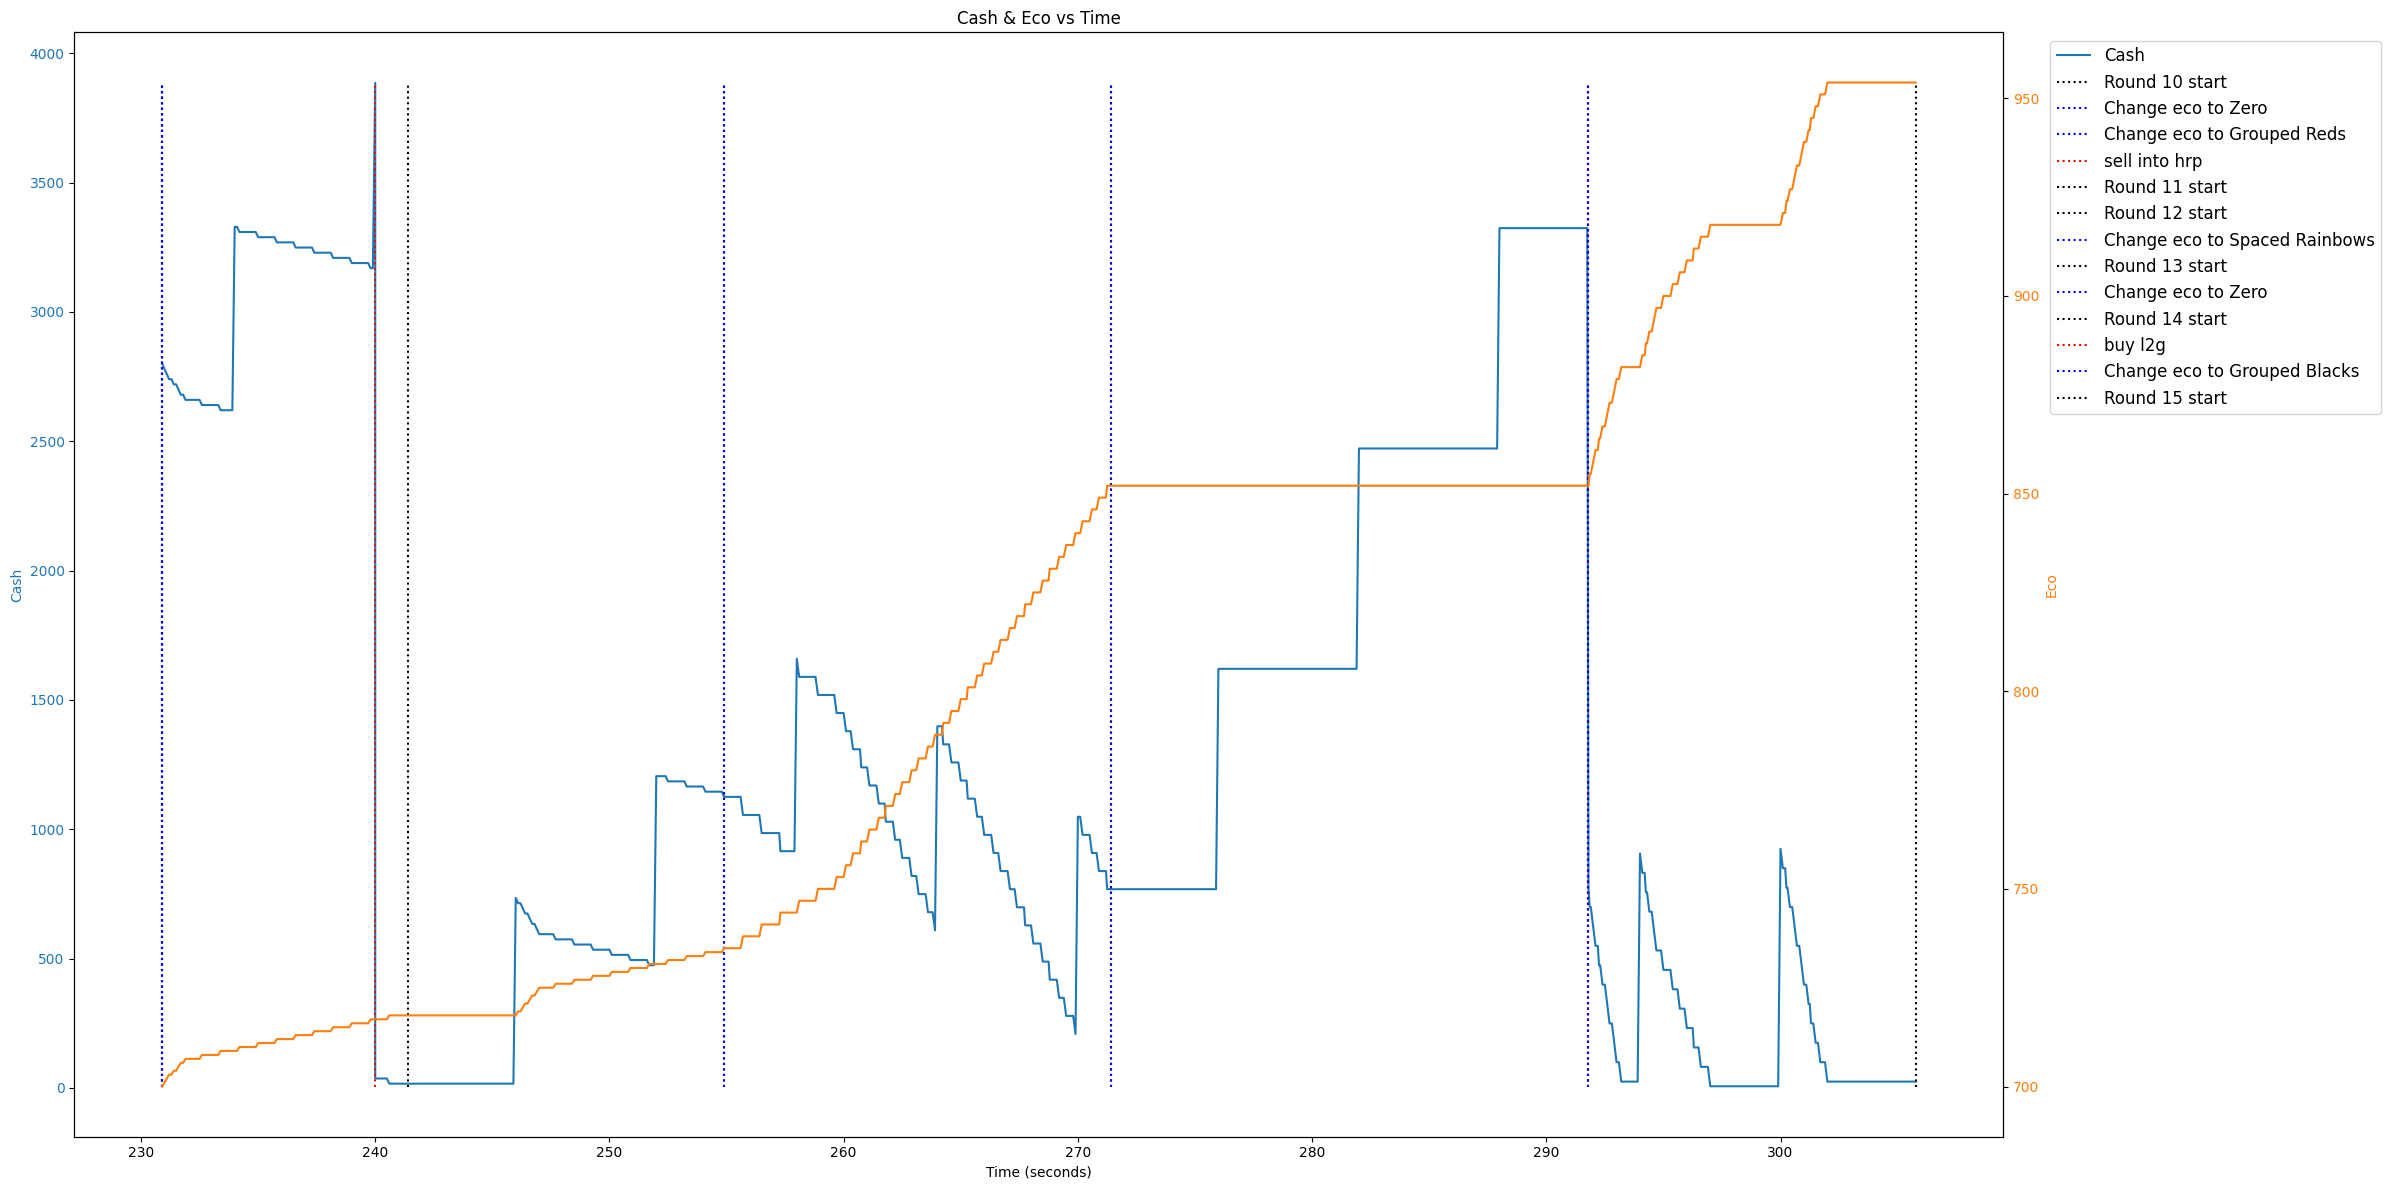

In [5]:
initial_state_game = {
    'Cash': 2800,
    'Eco': 700,
    'Rounds': rounds,
    'Game Round': 10,
    'Buy Queue': buy_queue,
    'Eco Queue': eco_queue
}

game_state = b2.GameState(initial_state_game)
game_state.fastForward(target_round = 15)
game_state.viewCashEcoHistory((24,12))
b2.writeLog(game_state.logs, filename = 'using_queues')
print("The current cash and eco are (%s,%s)"%(game_state.cash, game_state.eco))